## Libraries

In [19]:
# linear algebra and data processing
import numpy as np
import pandas as pd 

import mlflow
#data visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# models + accuracy metrics
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error\

import sys



# saving models
import pickle
import gzip

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

# datasets path
import os
sys.path.append(os.path.abspath(os.path.join('../script')))
from config import Config

## Data

In [6]:
# data
na_value=['',' ','nan','Nan','NaN','na', '<Na>']
train_data = pd.read_csv('../Data/train.csv', na_values=na_value)
test_data = pd.read_csv('../Data/test.csv', na_values=na_value)
store_data = pd.read_csv('../Data/store.csv', na_values=na_value)
submission_data = pd.read_csv('../Data/sample_submission.csv', na_values=na_value)

print('train set shape:', train_data.shape)
print('test set shape:', test_data.shape)
print('store set shape:', store_data.shape)

train set shape: (1017209, 9)
test set shape: (41088, 8)
store set shape: (1115, 10)


In [7]:
# merge the train/test sets with the stores set
full_train = pd.merge(left = train_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
full_test = pd.merge(left = test_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
print(full_train.shape)
print(full_test.shape)

(1017209, 18)
(41088, 17)


In [8]:
# quick peak
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [9]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

## Preprocessing

In [10]:
def preprocess_data(full_train, full_test):
    
    # '''preprocessing'''
    global train_features, test_features, train_target, categorical, numerical

    # train and target features
    train_features = full_train.drop(['Sales', 'Customers'], axis = 1) #drop the target feature + customers (~ will not be used for prediction)
    train_target  = full_train[['Sales']]
    test_features = full_test.drop(['Id'], axis = 1) #drop id, it's required only during submission

    #feature generation + transformations
    train_features['Date'] = pd.to_datetime(train_features.Date)
    train_features['Month'] = train_features.Date.dt.month.to_list()
    train_features['Year'] = train_features.Date.dt.year.to_list()
    train_features['Day'] = train_features.Date.dt.day.to_list()
    train_features['WeekOfYear'] = train_features.Date.dt.weekofyear.to_list()
    train_features['DayOfWeek'] = train_features.Date.dt.dayofweek.to_list()
    train_features['weekday'] = 1        # Initialize the column with default value of 1
    train_features.loc[train_features['DayOfWeek'] == 5, 'weekday'] = 0
    train_features.loc[train_features['DayOfWeek'] == 6, 'weekday'] = 0
    # train_features = train_features.drop(['Date'], axis = 1)
    train_features = train_features.drop(['Store'], axis = 1)

    test_features['Date'] = pd.to_datetime(test_features.Date)
    test_features['Month'] = test_features.Date.dt.month.to_list()
    test_features['Year'] = test_features.Date.dt.year.to_list()
    test_features['Day'] = test_features.Date.dt.day.to_list()
    test_features['WeekOfYear'] = test_features.Date.dt.weekofyear.to_list()
    test_features['DayOfWeek'] = test_features.Date.dt.dayofweek.to_list()
    test_features['weekday'] = 1        # Initialize the column with default value of 1
    test_features.loc[test_features['DayOfWeek'] == 5, 'weekday'] = 0
    test_features.loc[test_features['DayOfWeek'] == 6, 'weekday'] = 0
    # test_features = test_features.drop(['Date'], axis = 1)
    test_features = test_features.drop(['Store'], axis = 1)


    # numerical and categorical columns (train set)
    categorical = []
    numerical = []
    timestamp = []

    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features]) #merge the features columns for uniform preprocessing

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64') 
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"



    # ''' actual preprocessing: the mighty pipeline '''
    # numeric
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean()))) 
    features.PromoInterval = features.PromoInterval.fillna(features.PromoInterval.mode()[0])
    features.Open = features.Open.fillna(features.Open.mode()[0])
    features = pd.get_dummies(features, columns=['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday'], drop_first=True)
    scaler = RobustScaler()
    c = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'WeekOfYear', 'Month', 'Year', 'Day', 'WeekOfYear', 'weekday']
    features[numerical] = scaler.fit_transform(features[numerical].values)


    return features

In [11]:
features = preprocess_data(full_train, full_test)
features = features.drop(['Date'], axis = 1)
features.head()

,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1,0.00,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,-0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,-0.50,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
4,-0.75,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [12]:
# reconstruct train and test sets
def reconstruct_sets(features):
    global x_train, x_val, y_train, y_val
    # global train_set
    # original train and test sets
    x_train = features.iloc[:len(train_features), :]
    x_test = features.iloc[len(train_features):, :]
    y_train = train_target
    # train_set = pd.concat([x_train, y_train], axis=1)

    # updated train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .20, random_state = 0)


    return x_train, x_val, y_train, y_val, x_test

In [13]:
x_train, x_val, y_train, y_val, x_test = reconstruct_sets(features)
# log transformation on target variable
y_train = np.log1p(y_train['Sales'])
y_val = np.log1p(y_val['Sales'])
x_train.shape, x_val.shape, y_train.shape, y_val.shape, x_test.shape

((813767, 25), (203442, 25), (813767,), (203442,), (41088, 25))

## Modelling 

In [15]:
features.to_csv('../features/my_features.csv')

In [25]:
# RandiomForestRegressor

#fitting
clf = RandomForestRegressor(n_estimators = 15)
#clf.fit(x_train, y_train)
mlflow.set_experiment("Random Forest Regressor")
mlflow.sklearn.autolog()
mlflow.sklearn.autolog()
with mlflow.start_run(run_name="RF-baseline"):
    clf.fit(x_train, y_train)

# validation
y_pred = clf.predict(x_val)
mean_squared_error(y_val, y_pred)
print("Mean squared error for RF on validation data =", mean_squared_error(y_val, y_pred))
print("Mean absolute error for RF on validation data =", mean_absolute_error(y_val, y_pred))

INFO: 'Random Forest Regressor' does not exist. Creating a new experiment
Mean squared error for RF on validation data = 0.018742081867053756
Mean absolute error for RF on validation data = 0.07629952412226534


In [20]:
# LinearRegression

#fitting
regressor = LinearRegression()
mlflow.set_experiment("Linear Regressor")
mlflow.sklearn.autolog()
mlflow.sklearn.autolog()
with mlflow.start_run(run_name="lr-baseline"):
    regressor.fit(x_train, y_train)


#validation
# scores = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 5)
regressor_pred = regressor.predict(x_val)
print("Mean squared error for sLR on validation data =", mean_squared_error(y_val, regressor_pred))
print("Mean absolute error for SLR on validation data =", mean_absolute_error(y_val, regressor_pred))

INFO: 'Linear Regressor' does not exist. Creating a new experiment
Mean squared error for sLR on validation data = 0.11848353838195072
Mean absolute error for SLR on validation data = 0.2527261289148485


In [24]:
# ExtremeBooster

#fitting
xgb = XGBRegressor(random_state = 42)
mlflow.set_experiment("Extereme Booster")
mlflow.sklearn.autolog()
mlflow.sklearn.autolog()
with mlflow.start_run(run_name="xgb-baseline"):
     xgb.fit(x_train, y_train)
#xgb.fit(x_train, y_train)

# validation
# scores = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = 5)
xgb_pred = xgb.predict(x_val)
print("Mean absolute error for xgb on validation data =", mean_absolute_error(y_val, xgb_pred))
print("Mean squared error for xgb on validation data =", mean_squared_error(y_val, xgb_pred))

Mean absolute error for xgb on validation data = 0.12452821718981408
Mean squared error for xgb on validation data = 0.03187673969685498


In [22]:
# GradientBooster

#fitting
gdb = GradientBoostingRegressor(random_state = 5)
mlflow.set_experiment("Gradient Booster")
mlflow.sklearn.autolog()
mlflow.sklearn.autolog()
with mlflow.start_run(run_name="gdb-baseline"):
     gdb.fit(x_train, y_train)

#gdb = gdb.fit(x_train, y_train)

#validation
gdb_pred = gdb.predict(x_val)
print("Mean absolute error for gdb on validation data =", mean_absolute_error(y_val, gdb_pred))
print("Mean squared error for gdb on validation data =", mean_squared_error(y_val, gdb_pred))

Mean absolute error for gdb on validation data = 0.2217410065237111
Mean squared error for gdb on validation data = 0.0966456895614806


Random Forest and XGB have a good performance.
Going the MSE way: RandomForest is the ideal one.

In [19]:
# save the model
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)
        
save_zipped_pickle(clf, 'compressed.pkl') #rf
save_zipped_pickle(clf, 'compressed_xgb.pkl') #xgb
save_zipped_pickle(clf, 'compressed_gb.pkl') #gb

## Predictions

In [21]:
# make predictions using the random forest model
final_pred = clf.predict(x_test)
final_pred.shape

(41088,)

In [22]:
'''reconstruct a df with StoreID, date and Sales columns using the predcitions and the test set then save it as a csv file'''

sub = full_test[['Id']]
back = np.expm1(final_pred)
sub['Sales'] = back
sub['Date'] = full_test.Date.to_list()
sub['Store'] = full_test.Store.to_list()
sub.to_csv('sub_plot.csv', index = False)

## Pred Plot

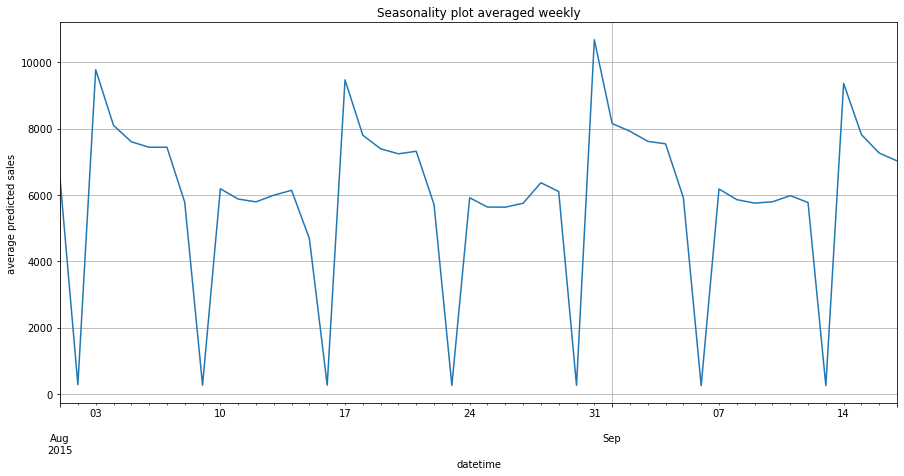

In [23]:
time_data = sub[['Date', 'Sales']]
time_data['datetime'] = pd.to_datetime(time_data['Date'])
time_data = time_data.set_index('datetime')
time_data = time_data.drop(['Date'], axis = 1)
monthly_time_data = time_data.Sales.resample('D').mean() 
plt.figure(figsize = (15,7))
plt.title('Seasonality plot averaged weekly')
plt.ylabel('average predicted sales')
monthly_time_data.plot()
plt.grid()